# Training Chest X-Ray Images

## 1. Data preprocessing

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1. Text dataset

In [2]:
# Loading the text dataset
labels = pd.read_csv("./dataset/text dataset/6. dataset.csv")
labels = labels.drop("Unnamed: 0", axis = 1)
labels.head()

,Image Index,No Finding,Infiltration,Atelectasis,Effusion,Pneumothorax
0,00011596_004_90degree.jpg,0,0,1,0,0
1,00011156_005_flipped_180degree.jpg,0,0,1,0,0
2,00011596_005_flipped_90degree.jpg,0,0,1,0,0
3,00002955_004_flipped_270degree.jpg,0,0,1,0,0
4,00003406_002.png,1,0,0,0,0


In [3]:
# Splitting the data into X and y
X_files = labels['Image Index']
y = labels.iloc[:, 1:]
y = np.array(y)

In [4]:
# Adding the full path to each image
X = []
for index, i_img in tqdm(enumerate(X_files), total = len(X_files)):
    X.append("./dataset/image dataset/" + i_img)

100%|██████████| 129816/129816 [00:00<00:00, 1345700.13it/s]


In [5]:
X[:5]

['./dataset/image dataset/00011596_004_90degree.jpg',
 './dataset/image dataset/00011156_005_flipped_180degree.jpg',
 './dataset/image dataset/00011596_005_flipped_90degree.jpg',
 './dataset/image dataset/00002955_004_flipped_270degree.jpg',
 './dataset/image dataset/00003406_002.png']

In [6]:
y[:5]

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

In [7]:
print("We have", len(labels), "total dataset")
print("Total number of images in training set: ", int(len(labels)*0.9))
print("Total number of images in validation set: ", int(len(labels)*0.05))
print("Total number of images in test set: ", int(len(labels)*0.05))

We have 129816 total dataset
Total number of images in training set:  116834
Total number of images in validation set:  6490
Total number of images in test set:  6490


In [8]:
train_files, train_targets = X[:116834], y[:116834]
val_files, val_targets = X[116834:123324], y[116834:123324]
test_files, test_targets = X[123324:], y[123324:]

### 1.2. Image dataset

In [9]:
# Importing the libraries
import keras
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

Using TensorFlow backend.


In [10]:
def path_to_tensor(img_path):
    """
    Getting a tensor from a given path.
    """
    # Loading the image
    img = image.load_img(img_path, target_size=(256, 256))
    # Converting the image to numpy array
    x = image.img_to_array(img)   
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    # Getting a list of tensors from a given path directory.
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
# Preprocessing the image dataset
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255
val_tensors = paths_to_tensor(val_files).astype('float32')/255

100%|██████████| 6490/6490 [00:50<00:00, 127.88it/s]


In [12]:
# Saving the tensors
np.save("./saved image tensors/training_tensors.npy", train_tensors)
np.save("./saved image tensors/test_tensors.npy", test_tensors)
np.save("./saved image tensors/validation_tensors.npy", val_tensors)

In [11]:
# Loading the data  
train_tensors = np.load("./saved image tensors/training_tensors.npy")
test_tensors = np.load("./saved image tensors/test_tensors.npy")
val_tensors = np.load("./saved image tensors/validation_tensors.npy")

# 2. Training the model

In [12]:
# Importing the keras libraries
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard

### 2.1. MobileNet architecture

In [14]:
def mobilenet_architecture():
    """
    Pre-build architecture of mobilenet for our dataset.
    """
    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (256, 256, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    mobilenet_model = Model(base_model.input, output)
    
    # Getting the summary of architecture
    #mobilenet_model.summary()
    
    # Compiling the model
    mobilenet_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

    return mobilenet_model

In [15]:
# Getting the mobilenet
mobilenet_model = mobilenet_architecture()

In [15]:
checkpointer = ModelCheckpoint(filepath='saved models/weights.best.mobilenet.hdf5', 
                               verbose=1, 
                               save_best_only=True)

mobilenet_model.fit(train_tensors, 
                    train_targets, 
                    batch_size = 64,
                    validation_data = (val_tensors, val_targets),
                    epochs = 5,
                    callbacks=[checkpointer], 
                    verbose=1)

Train on 116834 samples, validate on 6490 samples
Epoch 1/5
116834/116834 [==============================] - 2143s - loss: 0.9555 - acc: 0.5614 - val_loss: 0.9506 - val_acc: 0.5888
Epoch 2/5
116834/116834 [==============================] - 2127s - loss: 0.8557 - acc: 0.6237 - val_loss: 0.9916 - val_acc: 0.5804
Epoch 3/5
116834/116834 [==============================] - 2127s - loss: 0.8127 - acc: 0.6491 - val_loss: 0.9526 - val_acc: 0.5920
Epoch 4/5
116834/116834 [==============================] - 2130s - loss: 0.7783 - acc: 0.6693 - val_loss: 0.8388 - val_acc: 0.6385
Epoch 5/5
116834/116834 [==============================] - 2131s - loss: 0.7419 - acc: 0.6889 - val_loss: 0.7662 - val_acc: 0.6710


In [16]:
checkpointer = ModelCheckpoint(filepath='saved models/weights.best.mobilenet.hdf5', 
                               verbose=1, 
                               save_best_only=True)

mobilenet_model.fit(train_tensors, 
                    train_targets, 
                    batch_size = 64,
                    validation_data = (val_tensors, val_targets),
                    epochs = 5,
                    callbacks=[checkpointer], 
                    verbose=1)

Train on 116834 samples, validate on 6490 samples
Epoch 1/5
116834/116834 [==============================] - 2125s - loss: 0.7089 - acc: 0.7069 - val_loss: 0.7961 - val_acc: 0.6729
Epoch 2/5
116834/116834 [==============================] - 2123s - loss: 0.6778 - acc: 0.7224 - val_loss: 0.9186 - val_acc: 0.6499
Epoch 3/5
116834/116834 [==============================] - 2126s - loss: 0.6424 - acc: 0.7402 - val_loss: 0.7536 - val_acc: 0.6812
Epoch 4/5
116834/116834 [==============================] - 2125s - loss: 0.6050 - acc: 0.7573 - val_loss: 0.7774 - val_acc: 0.6823
Epoch 5/5
116834/116834 [==============================] - 2124s - loss: 0.5596 - acc: 0.7780 - val_loss: 0.8171 - val_acc: 0.6797


In [ ]:
# Loading the weights
mobilenet_model.load_weights("./saved models/weights.best.mobilenet.hdf5")

### 2.2. Inception architecture

In [16]:
def inception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model 
    from keras.applications.inception_v3 import InceptionV3

    # Pre-build model
    base_model = InceptionV3(include_top = False, weights = None, input_shape = (256, 256, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    inception_model = Model(base_model.input, output)
    
    # Summary of the model
    #inception_model.summary()
    
    # Compiling the model
    inception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])
    
    return inception_model

In [17]:
# Getting the inception
inception_model = inception_architecture()

In [15]:
checkpointer = ModelCheckpoint(filepath='saved models/weights.best.inception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

inception_model.fit(train_tensors, 
                    train_targets, 
                    batch_size = 64,
                    validation_data = (val_tensors, val_targets),
                    epochs = 10,
                    callbacks=[checkpointer], 
                    verbose=1)

Train on 116834 samples, validate on 6490 samples
Epoch 1/10
116834/116834 [==============================] - 3740s - loss: 0.9602 - acc: 0.5703 - val_loss: 1.0347 - val_acc: 0.5425
Epoch 2/10
116834/116834 [==============================] - 3709s - loss: 0.8520 - acc: 0.6309 - val_loss: 0.8690 - val_acc: 0.6156
Epoch 3/10
116834/116834 [==============================] - 3712s - loss: 0.8183 - acc: 0.6500 - val_loss: 0.8227 - val_acc: 0.6382
Epoch 4/10
116834/116834 [==============================] - 3712s - loss: 0.7848 - acc: 0.6672 - val_loss: 3.0529 - val_acc: 0.4569
Epoch 5/10
116834/116834 [==============================] - 3710s - loss: 0.7588 - acc: 0.6827 - val_loss: 0.8736 - val_acc: 0.6262
Epoch 6/10
116834/116834 [==============================] - 3712s - loss: 0.7280 - acc: 0.7003 - val_loss: 0.8212 - val_acc: 0.6593
Epoch 7/10
116834/116834 [==============================] - 3705s - loss: 0.7010 - acc: 0.7143 - val_loss: 0.7513 - val_acc: 0.6884
Epoch 8/10
116834/116834 [

In [ ]:
# Loading the weights
inception_model.load_weights("./saved models/weights.best.inception.hdf5")

### 2.3. Xception architecture

In [18]:
def xception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model
    from keras.applications.xception import Xception

    # Pre-build model
    base_model = Xception(include_top = False, weights = None, input_shape = (256, 256, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    xception_model = Model(base_model.input, output)

    # Summary of the model
    #xception_model.summary()
    
    # Compiling the model
    xception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.0001), 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

    return xception_model

In [19]:
# Getting the xception
xception_model = xception_architecture()

In [20]:
tensor_board = TensorBoard(log_dir='./logs', histogram_freq = 0, batch_size = 32)

checkpointer = ModelCheckpoint(filepath='saved models/weights.best.xception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

xception_model.fit(train_tensors, 
                   train_targets, 
                   batch_size = 32,
                   validation_data = (val_tensors, val_targets),
                   epochs = 10,
                   callbacks=[checkpointer, tensor_board], 
                   verbose=1)

Train on 116834 samples, validate on 6490 samples
Epoch 1/10
116834/116834 [==============================] - 6119s - loss: 0.8774 - acc: 0.6104 - val_loss: 0.9727 - val_acc: 0.5613
Epoch 2/10
116834/116834 [==============================] - 6107s - loss: 0.7734 - acc: 0.6705 - val_loss: 0.7824 - val_acc: 0.6700
Epoch 3/10
116834/116834 [==============================] - 6104s - loss: 0.7167 - acc: 0.7022 - val_loss: 0.9355 - val_acc: 0.6173
Epoch 4/10
116834/116834 [==============================] - 6102s - loss: 0.6574 - acc: 0.7331 - val_loss: 0.8751 - val_acc: 0.6501
Epoch 5/10
   128/116834 [..............................] - ETA: 6017s - loss: 0.6869 - acc: 0.6797

KeyboardInterrupt: 

In [ ]:
# Loading the weights
xception_model.load_weights("./Saved models/weights.best.xception.hdf5")

### 2.4. Enseble model

In [13]:
from keras.layers import Input

In [14]:
# Single input for multiple models
model_input = Input(shape=(256, 256, 3))

In [15]:
def mobilenet_architecture():
    """
    Pre-build architecture of mobilenet for our dataset.
    """
    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_tensor = model_input)

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    mobilenet_model = Model(base_model.input, output)
    
    # Getting the summary of architecture
    #mobilenet_model.summary()
    
    # Compiling the model
    mobilenet_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

    return mobilenet_model

In [16]:
# Model 1
mobilenet_model = mobilenet_architecture()
mobilenet_model.load_weights("./saved models/weights.best.mobilenet.hdf5")

In [17]:
def inception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model 
    from keras.applications.inception_v3 import InceptionV3

    # Pre-build model
    base_model = InceptionV3(include_top = False, weights = None, input_tensor = model_input)

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    inception_model = Model(base_model.input, output)
    
    # Summary of the model
    #inception_model.summary()
    
    # Compiling the model
    inception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])
    
    return inception_model

In [18]:
# Model 2
inception_model = inception_architecture()
inception_model.load_weights("./saved models/weights.best.inception.hdf5")

In [19]:
def xception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model
    from keras.applications.xception import Xception

    # Pre-build model
    base_model = Xception(include_top = False, weights = None, input_tensor = model_input)

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    xception_model = Model(base_model.input, output)

    # Summary of the model
    #xception_model.summary()
    
    # Compiling the model
    xception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.0001), 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

    return xception_model

In [20]:
# Model 3
xception_model = xception_architecture()
xception_model.load_weights("./Saved models/weights.best.xception.hdf5")

In [21]:
# Appending all models
models = [mobilenet_model, inception_model, xception_model]

In [22]:
def ensemble(models, model_input):
    """
    Ensembling multiple models.
    """
    # Getting the output of all models
    outputs = [model.outputs[0] for model in models]
    # Avereging all outputs to one
    y = keras.layers.Average()(outputs)
    # Making a new model with one input and avereged output
    model = Model(model_input, y, name='ensemble')
    
    return model

In [23]:
# Getting ensemble model
ensemble_model = ensemble(models, model_input)

In [31]:
image_to_predict = path_to_tensor(test_files[0]).astype('float32')/255.
ensemble_model.predict(image_to_predict)

array([[ 0.00069966,  0.18764496,  0.43724325,  0.1686523 ,  0.20575982]], dtype=float32)

In [32]:
test_targets[0]

array([0, 0, 1, 0, 0])

## 3. Prediction

In [33]:
model_architecture = ensemble_model

In [34]:
def predict(img_path, 
            model_architecture = model_architecture):
    # Getting the tensor of image
    image_to_predict = path_to_tensor(img_path).astype('float32')/255
    # Getting the model's architecture
    model = model_architecture
    # Loading the weights
    #model.load_weights(path_model_weight)
    # Predicting
    pred = model.predict(image_to_predict)
    print("Prediction..." + " Melanoma : ", pred[0][0], " | Other : ", pred[0][1])
    if np.argmax(pred) == 0:
        return [1., 0.]
    elif np.argmax(pred) == 1:
        return [0., 1.]

### 3.1. Predicting with mobilenet

In [ ]:
model_architecture = mobilenet_architecture()
weight_path = "./saved models/weights.best.mobilenet.hdf5"

In [ ]:
predict("./dataset/image dataset/")

### 3.2. Predicting with inception

In [ ]:
model_architecture = inception_architecture()
weight_path = "./saved models/weights.best.mobilenet.hdf5"

In [ ]:
predict("./dataset/image dataset/")

### 3.3. Predicting with xception

In [ ]:
model_architecture = xception_architecture()
xception_model.load_weights("./saved models/weights.best.xception.hdf5")

In [ ]:
predict("./dataset/image dataset/")

## 4. Evaluating ensemble model

In [24]:
# Importing the libraries
from sklearn.metrics import roc_curve, auc
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def compute_roc(y_true, y_score):
    """ 
    Computing the "Receiving Operating Characteristic curve" and area
    """
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score) 
    auroc = auc(false_positive_rate, true_positive_rate) 
    return false_positive_rate, true_positive_rate, auroc

In [26]:
def plot_roc(y_true, y_score):
    """ 
    Ploting the Receiving Operating Characteristic curve
    """
    false_positive_rate, true_positive_rate, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw=2, 
             label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic example', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [27]:
def positive_negative_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [39]:
from tqdm import tqdm

In [35]:
# Compute test set predictions
LENGTH_OF_TESTING = len(test_targets)

y_true = test_targets
y_score = []
for index in tqdm(range(LENGTH_OF_TESTING)): #compute one at a time due to memory constraints
    image_to_predict = path_to_tensor(test_files[index]).astype("float32")/255.
    probs = ensemble_model.predict(image_to_predict)
    if np.argmax(probs) == 0:
        y_score.append([1., 0., 0., 0., 0.])
        
    elif np.argmax(probs) == 1:
        y_score.append([0., 1., 0., 0., 0.])
        
    elif np.argmax(probs) == 2:
        y_score.append([0., 0., 1., 0., 0.])
        
    elif np.argmax(probs) == 3:
        y_score.append([0., 0., 0., 1., 0.])
        
    elif np.argmax(probs) == 4:
        y_score.append([0., 0., 0., 0., 1.])
    
correct = np.array(y_true) == np.array(y_score)

100%|██████████| 6492/6492 [13:22<00:00,  8.09it/s]


In [257]:
def evaluate_column(COLOUMN_NUM):
    
    y_true_2 = []
    y_score_2 = []

    # Getting the relavant coloumn
    for i_row in tqdm(range(len(y_true))):
        y_score_2.append(y_score[i_row][COLOUMN_NUM])
        y_true_2.append(y_true[i_row][COLOUMN_NUM])

    # Plotting the receiver operating charachteristic
    plot_roc(y_true_2, y_score_2)

    # Getting the true and false, positives and negatives
    TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
    postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                          [FALSE_NEGATIVE, TRUE_NEGATIVE]]


    # PLotting the heatmap
    import seaborn as sns
    sns.set()
    l =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_NEGATIVE)]])
    plt.figure(figsize = (13, 10))
    sns.heatmap(postives_negatives, annot = l, linewidths = 0.1, fmt="", cmap = 'Blues')

    # Sensitivity | Recall | hit rate | true positive rate (TPR)
    sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
    print("Sensitivity: ", sensitivity)

    # Specificity | selectivity | true negative rate (TNR)
    specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
    print("Specifity: ", specifity)

    # Precision | positive predictive value (PPV)
    predcision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
    print("Precision: ", predcision)

    # Negative predictive value (NPV)
    npv = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
    print("Negative predictive value: ", npv)

    # Accuracy 
    accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
    print("Accuracy: ", accuracy)

### 4.1. Evaluating 'Normal'

In [258]:
plt.style.available
plt.style.use("seaborn-white")

100%|██████████| 6492/6492 [00:00<00:00, 620048.31it/s]


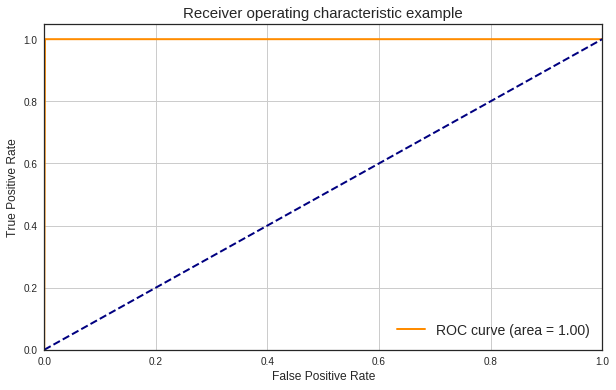

Sensitivity:  1.0
Specifity:  1.0
Precision:  0.9946319018404908
Negative predictive value:  1.0
Accuracy:  0.9989217498459643


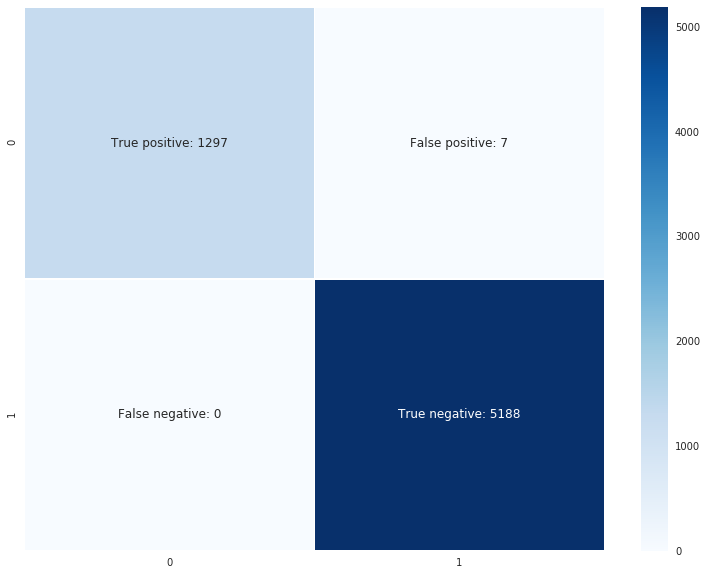

In [259]:
evaluate_column(COLOUMN_NUM = 0)

### 4.2. Evaluating 'Infiltration'

In [235]:
plt.style.available
plt.style.use("seaborn-white")

100%|██████████| 6492/6492 [00:00<00:00, 636558.39it/s]


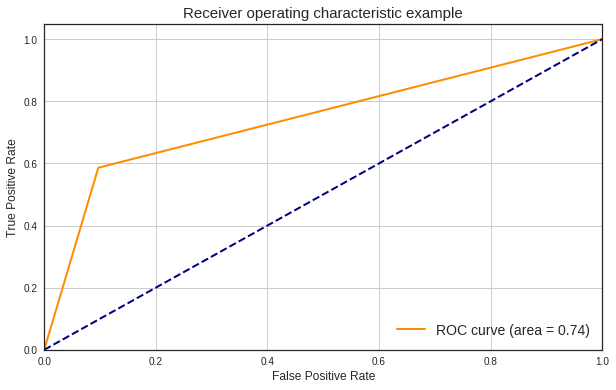

Sensitivity:  0.5860805860805861
Specifity:  0.8912415784408084
Precision:  0.6168080185042406
Negative predictive value:  0.8912415784408084
Accuracy:  0.8364140480591498


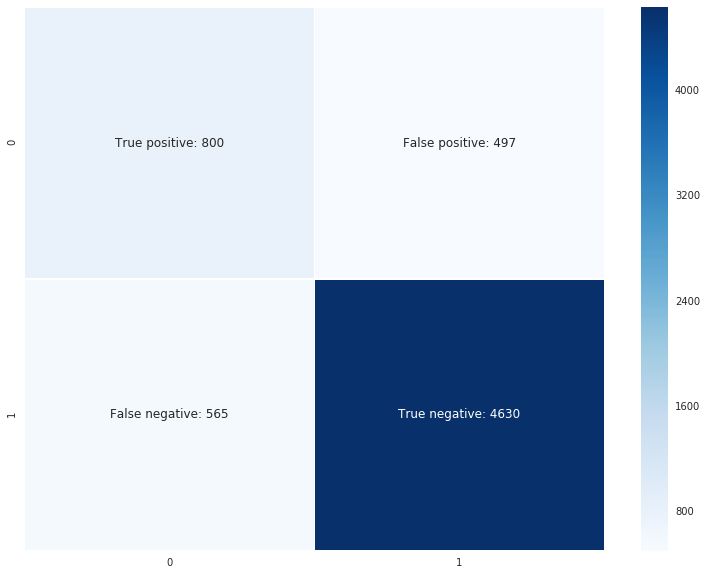

In [236]:
evaluate_column(COLOUMN_NUM = 1)

### 4.3. Evaluating 'Atelectasis'

In [237]:
plt.style.available
plt.style.use("seaborn-white")

100%|██████████| 6492/6492 [00:00<00:00, 621038.24it/s]


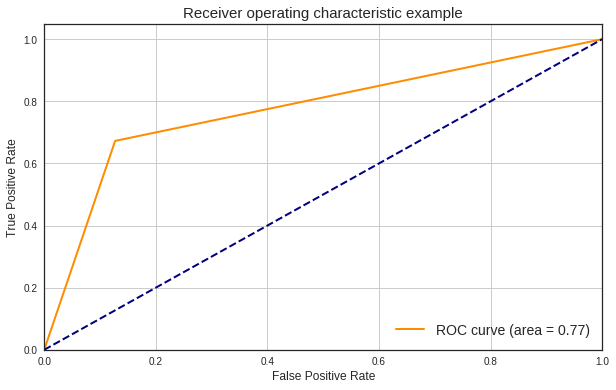

Sensitivity:  0.6724659606656581
Specifity:  0.9124545086938941
Precision:  0.57503234152652
Negative predictive value:  0.9124545086938941
Accuracy:  0.8321010474430067


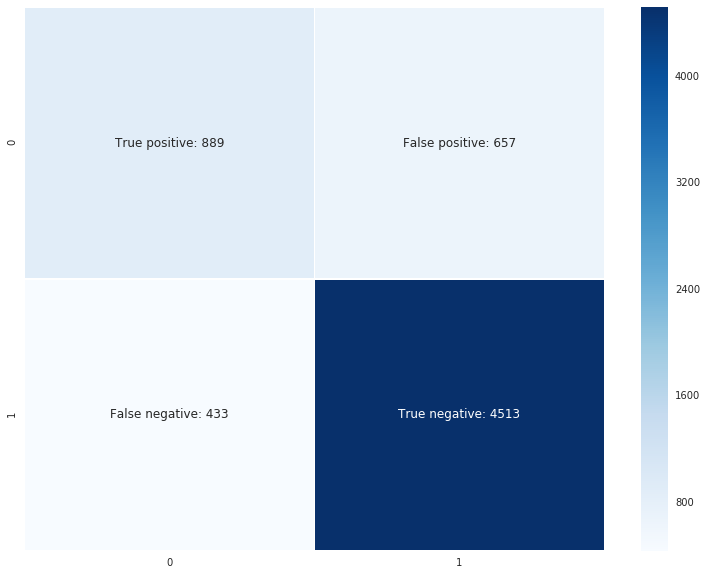

In [238]:
evaluate_column(COLOUMN_NUM = 2)

### 4.4. Evaluating 'Effusion'

In [239]:
plt.style.available
plt.style.use("seaborn-white")

100%|██████████| 6492/6492 [00:00<00:00, 619907.15it/s]


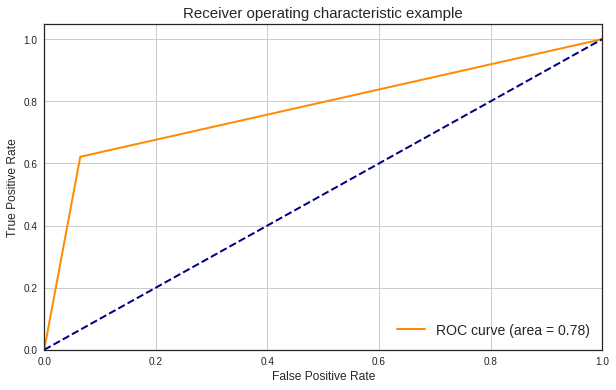

Sensitivity:  0.6214285714285714
Specifity:  0.9111897225842488
Precision:  0.6984834968777877
Negative predictive value:  0.9111897225842488
Accuracy:  0.8744608749229821


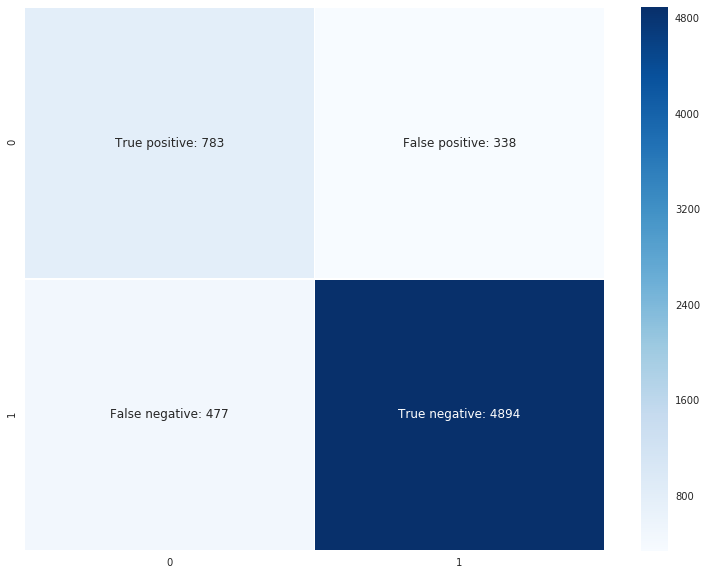

In [240]:
evaluate_column(COLOUMN_NUM = 3)

### 4.5. Evaluating 'Pneumothorax'

In [241]:
plt.style.available
plt.style.use("seaborn-white")

100%|██████████| 6492/6492 [00:00<00:00, 607392.85it/s]


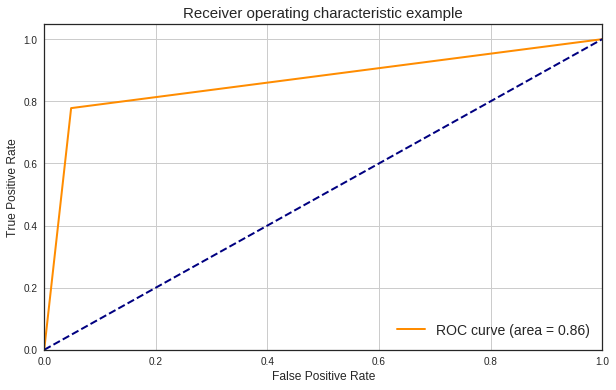

Sensitivity:  0.7780448717948718
Specifity:  0.9474183750949127
Precision:  0.7933006535947712
Negative predictive value:  0.9474183750949127
Accuracy:  0.9183610597658657


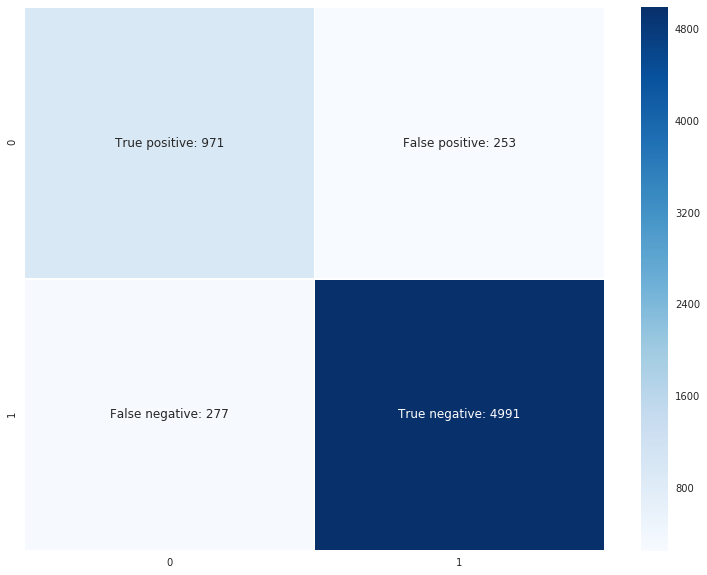

In [242]:
evaluate_column(COLOUMN_NUM = 4)

### 4.5. Evaluating total dataset

In [181]:
y_score_2 = [] 
y_true_2 = []

for index in tqdm(range(len(y_score))):
    if y_score[index] == y_true[index]: 
        y_score_2.append(1)
    else:
        y_score_2.append(0)

100%|██████████| 6492/6492 [00:00<00:00, 606891.96it/s]


In [184]:
accuracy = np.sum(y_score_2) / len(y_score_2)
print("Total accuracy: ", accuracy)

Total accuracy:  0.730129390018


## 5. Localization

In [28]:
# Importing the libraries
from keras.applications.mobilenet import preprocess_input
import scipy
import cv2

In [29]:
def getting_two_layer_weights(path_model_weight):
    # The model

    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (256, 256, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'softmax')(x)
    x = Dense(units = 512, activation = 'softmax')(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    #model.summary()

    # Compiling the model
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    # loading the weights
    model.load_weights(path_model_weight)
    
    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    # Extracting the wanted output
    mobilenet_model = Model(inputs = model.input, outputs = (model.layers[-5].output, model.layers[-1].output))
    
    return mobilenet_model, all_amp_layer_weights


def mobilenet_CAM(img_path, model, all_amp_layer_weights):
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = model.predict(path_to_tensor(img_path)) 
    
    # Eliminating dimensions of one    
    last_conv_output = np.squeeze(last_conv_output)
    
    # Model's prediction
    predicted_class = np.argmax(predictions)
    
    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 0.5), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)
    
    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    
    
    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class


def plot_CAM(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    #im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (512, 512))
    im = path_to_tensor(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = mobilenet_CAM(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.1, interpolation='nearest', vmin=0, vmax=1)


In [42]:
img_path = test_files[344]

In [ ]:
mobilenet_model, all_amp_layer_weights = getting_two_layer_weights(path_to_model_weight)

In [570]:
final_output, predicted_class = mobilenet_CAM(img_path, mobilenet_model, all_amp_layer_weights)

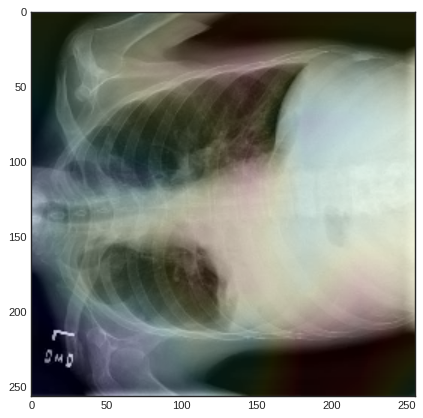

In [576]:
plot_CAM(img_path, plt, mobilenet_model, all_amp_layer_weights)

<hr>

## Localization 2

In [38]:
def getting_two_layer_weights():
    # The model
    model = ensemble_model

    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-2].get_weights()[0]

    # Extracting the wanted output
    ensembled_model = Model(inputs = model.input, outputs = (model.layers[-14].output, model.layers[-2].output))
    
    return ensembled_model, all_amp_layer_weights

In [39]:
def CAM_func(img_path, model, all_amp_layer_weights):
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = ensembled_model.predict(path_to_tensor(img_path)) 

    # Eliminating dimensions of one    
    last_conv_output = np.squeeze(last_conv_output)

    # Model's prediction
    predicted_class = np.argmax(predictions)

    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 0.25), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)

    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    

    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class

In [103]:
def plot_CAM(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    ax.figure(figsize = (10, 10))
    
    im = path_to_tensor(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), cmap= 'gray', vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = CAM_func(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(1-CAM, cmap = "jet", alpha = 0.3, interpolation='nearest', vmin=0, vmax=1)

In [41]:
img_path = test_files[344]

In [42]:
ensembled_model, all_amp_layer_weights = getting_two_layer_weights()

In [43]:
final_output, predicted_class = CAM_func(img_path, ensembled_model, all_amp_layer_weights)

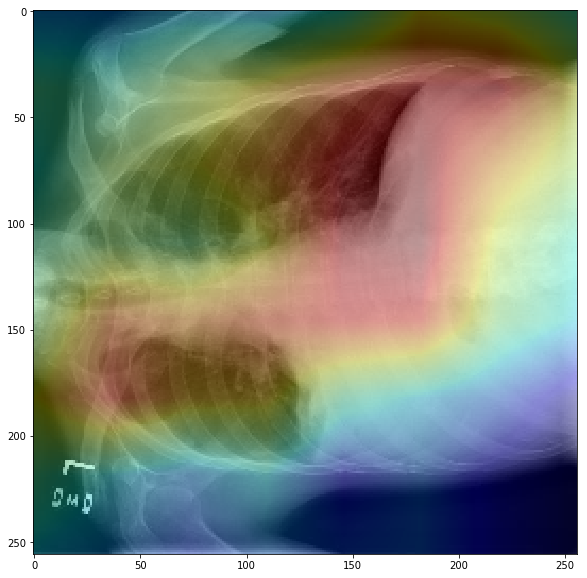

In [104]:
plot_CAM(img_path, plt, ensembled_model, all_amp_layer_weights)

In [55]:
plt.style.available

['ggplot',
 'Solarize_Light2',
 'bmh',
 'seaborn-dark',
 'seaborn-white',
 'grayscale',
 'seaborn-notebook',
 'seaborn-pastel',
 '_classic_test',
 'seaborn-poster',
 'seaborn-deep',
 'seaborn-whitegrid',
 'seaborn-muted',
 'seaborn-paper',
 'seaborn-ticks',
 'dark_background',
 'seaborn-talk',
 'seaborn-colorblind',
 'classic',
 'seaborn',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'fast',
 'fivethirtyeight',
 'seaborn-bright']

In [56]:
plt.style.use("seaborn-white")

In [45]:
im = path_to_tensor(img_path).astype("float32")/255.

In [46]:
im = im.squeeze()

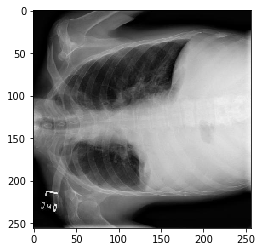

In [47]:
plt.imshow(im)

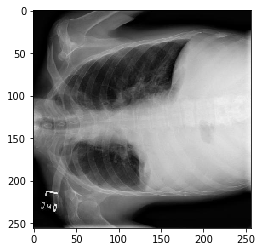

In [107]:
plt.imshow((path_to_tensor(img_path).astype('float32')/255).squeeze())

In [110]:
prediction = ensemble_model.predict(image_to_predict)
print(prediction)

[[  3.62620335e-06   1.70141626e-02   3.28433923e-02   9.44966137e-01
    5.17270202e-03]]


In [113]:
labels

,Image Index,No Finding,Infiltration,Atelectasis,Effusion,Pneumothorax
0,00011596_004_90degree.jpg,0,0,1,0,0
1,00011156_005_flipped_180degree.jpg,0,0,1,0,0
2,00011596_005_flipped_90degree.jpg,0,0,1,0,0
3,00002955_004_flipped_270degree.jpg,0,0,1,0,0
4,00003406_002.png,1,0,0,0,0
5,00022526_004_flipped_90degree.jpg,0,0,0,1,0
6,00016716_010_270degree.jpg,0,0,1,0,0
7,00011307_002.png,1,0,0,0,0
8,00005815_003_180degree.jpg,0,0,1,0,0
9,00020666_001_180degree.jpg,0,1,0,0,0


Image uploaded sucessfully!..(1/5)
Image preprocessed sucessfully!..(2/5)
Image localization calculated sucessfully!..(3/5)
Image plotted sucessfully!..(4/5)
Localized image plotted sucessfully!..(5/5)


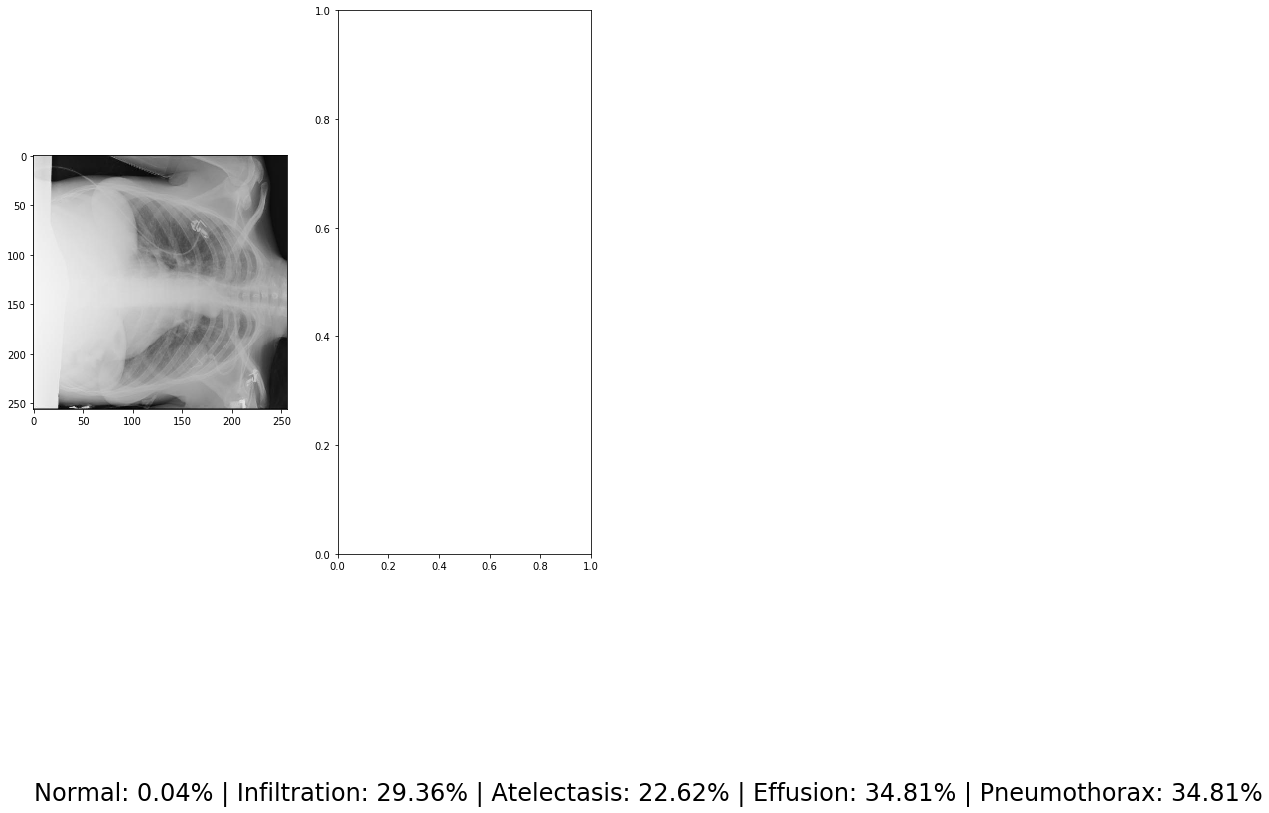

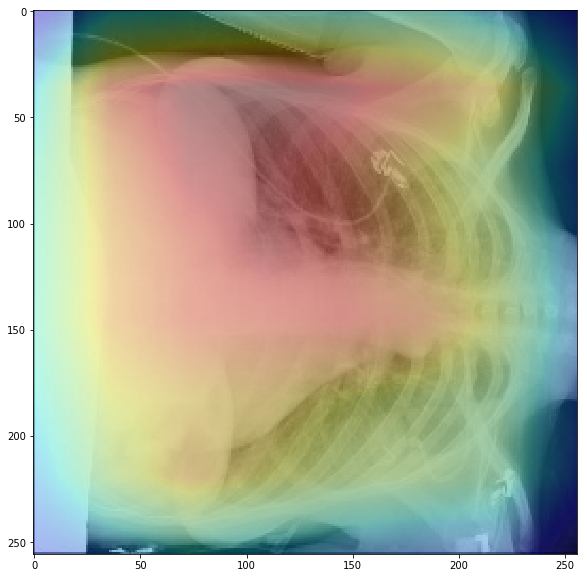

In [117]:
# Getting the image path
img_path = glob.glob("./dataset/image dataset/*")[7]

# Getting the image tensor
image_to_predict = path_to_tensor(img_path).astype('float32')/255
image_to_plot = path_to_tensor(img_path)

print("Image uploaded sucessfully!..(1/5)")
print("Image preprocessed sucessfully!..(2/5)")

# Getting the weights of last activation and last dense for localization
ensembled_model, all_amp_layer_weights = getting_two_layer_weights()

# Calculating the localization
final_output, predicted_class = CAM_func(img_path, ensembled_model, all_amp_layer_weights)

print("Image localization calculated sucessfully!..(3/5)")

# Predicting the image
prediction = ensemble_model.predict(image_to_predict)
prediction_final = "Normal: " + str(np.round(prediction[0][0]*100, decimals = 2)) + "%" + \
                   " | Infiltration: " + str(np.round(prediction[0][1]*100, decimals = 2)) + "%" + \
                   " | Atelectasis: " + str(np.round(prediction[0][2]*100, decimals = 2)) + "%" + \
                   " | Effusion: " + str(np.round(prediction[0][3]*100, decimals = 2)) + "%" + \
                   " | Pneumothorax: " + str(np.round(prediction[0][3]*100, decimals = 2)) + "%"

# Canvas initialization
plt.figure(figsize = (10, 10))

# First image
plt.subplot(121)
plt.imshow(image_to_predict.squeeze())
plt.text(0, 650, prediction_final, fontsize = 24)

print("Image plotted sucessfully!..(4/5)")

# Second image
plt.subplot(122)

# Plotting the image
plot_CAM(img_path, plt, mobilenet_model, all_amp_layer_weights)

print("Localized image plotted sucessfully!..(5/5)")

plt.show()